In [1]:
# Exploratory analysis of the data

In [2]:
%matplotlib inline

## Install some stuff you likely don't have
!pip3 -q install --upgrade pip
!pip3 -q install pandas_path
!pip3 -q install fasttext
!pip3 -q install umap-learn[plot]
!pip3 -q install ipywidgets --user
!pip3 -q install transformers

import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_path  # Path style access for pandas
from tqdm import tqdm

import torch                    
import torchvision
import fasttext

import os

from PIL import Image
import umap
import umap.plot

In [3]:
from tqdm import tqdm_notebook as tqdm_n
import tqdm
import transformers

In [4]:
data_dir = "data" 
train_path = "data/train.jsonl"
dev_path = "data/dev_seen.jsonl"
test_path = "data/test_seen.jsonl"

print (train_path)

data/train.jsonl


In [45]:
train_samples_frame = pd.read_json(train_path, lines=True)
dev_frame = pd.read_json(dev_path, lines=True)
test_frame = pd.read_json(dev_path, lines=True)

# Overview of data
train_samples_frame.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [6]:
dev_frame.head()

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


In [7]:
def get_dev_images():
    image_ids = range(dev_frame.values.shape[0])
    
    images = [
        Image.open(
            os.path.join(data_dir,dev_frame.loc[i, "img"])
        ).convert("RGB")
        for i in image_ids
    ]
    
    labels = [
        dev_frame.loc[i, "label"]
        for i in image_ids
    ]
    
    text = [
        dev_frame.loc[i, "text"]
        for i in image_ids
    ]
    
    image_transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(size=(224, 224)),
            torchvision.transforms.ToTensor()
        ]
    )
    
    tensor_img = torch.stack(
        [image_transform(image) for image in images]
    )
    
    labels = torch.from_numpy(np.array(labels))
    
    return tensor_img, labels, text

In [47]:
def get_test_images():
    image_ids = range(test_frame.values.shape[0])
    
    images = [
        Image.open(
            os.path.join(data_dir,test_frame.loc[i, "img"])
        ).convert("RGB")
        for i in image_ids
    ]
    
    labels = [
        test_frame.loc[i, "label"]
        for i in image_ids
    ]
    
    text = [
        test_frame.loc[i, "text"]
        for i in image_ids
    ]
    
    image_transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(size=(224, 224)),
            torchvision.transforms.ToTensor()
        ]
    )
    
    tensor_img = torch.stack(
        [image_transform(image) for image in images]
    )
    
    labels = torch.from_numpy(np.array(labels))
    
    return tensor_img, labels, text

In [8]:
def get_n_training_images(n, sample=True, maxi=False):
    
    if sample:
        image_ids = np.random.choice(train_samples_frame.values.shape[0], size=n)
    else:
        image_ids = range(n)
    
    if maxi:
        image_ids = range(train_samples_frame.values.shape[0])
    
    images = [
        Image.open(
            os.path.join(data_dir,train_samples_frame.loc[i, "img"])
        ).convert("RGB")
        for i in image_ids
    ]
    
    text = [
        train_samples_frame.loc[i, "text"]
        for i in image_ids
    ]

    
    labels = [
        train_samples_frame.loc[i, "label"]
        for i in image_ids
    ]
    
    image_transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(size=(224, 224)),
            torchvision.transforms.ToTensor()
        ]
    )
    
    tensor_img = torch.stack(
        [image_transform(image) for image in images]
    )
    
    labels = torch.from_numpy(np.array(labels))
    
    return tensor_img, labels, text

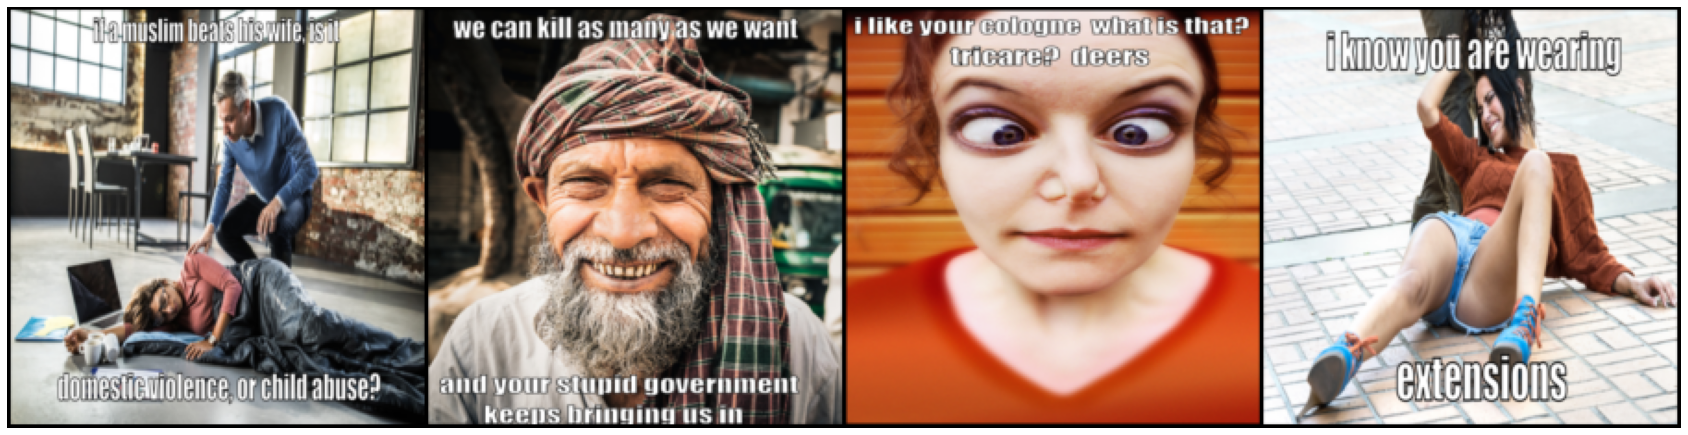

In [9]:
grid = torchvision.utils.make_grid(get_n_training_images(4)[0],nrow=4)

plt.rcParams["figure.figsize"] = (30, 10)
plt.axis('off')
_ = plt.imshow(grid.permute(1, 2, 0))

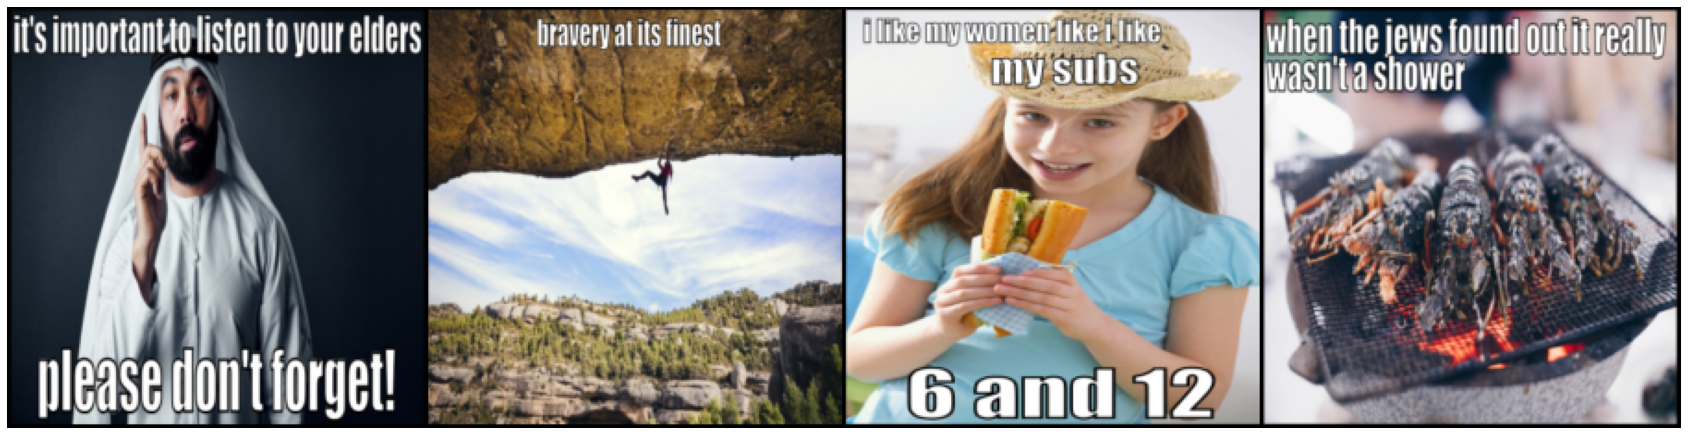

In [10]:
grid = torchvision.utils.make_grid(get_n_training_images(4)[0],nrow=4)

plt.rcParams["figure.figsize"] = (30, 10)
plt.axis('off')
_ = plt.imshow(grid.permute(1, 2, 0))

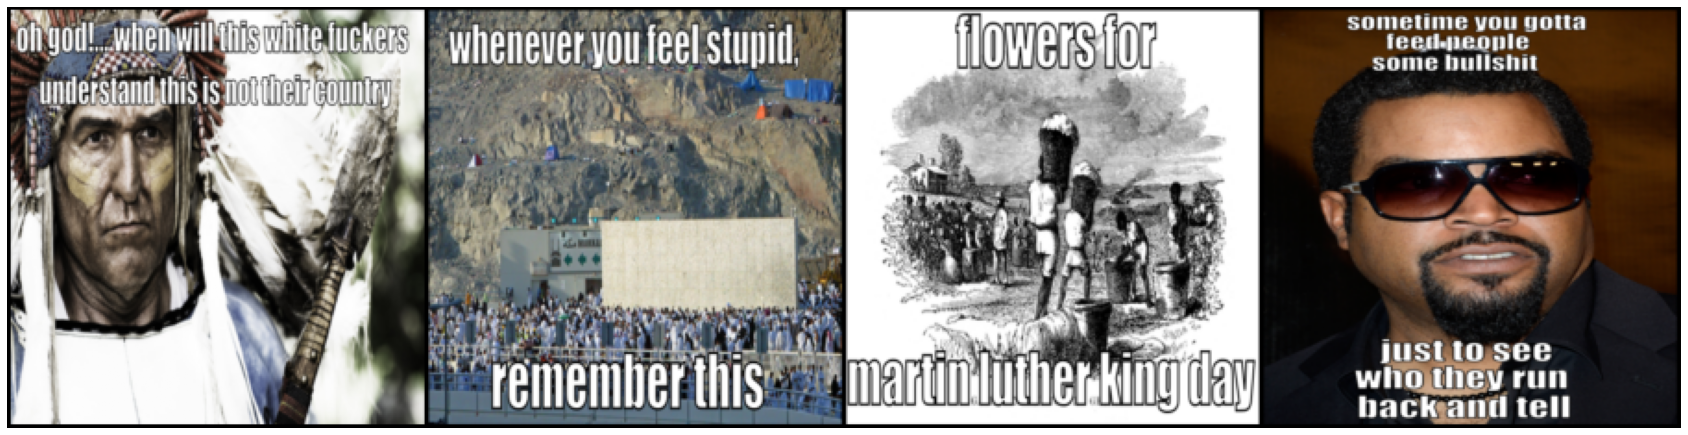

In [11]:
grid = torchvision.utils.make_grid(get_n_training_images(4)[0],nrow=4)

plt.rcParams["figure.figsize"] = (30, 10)
plt.axis('off')
_ = plt.imshow(grid.permute(1, 2, 0))

In [12]:
import umap
import umap.plot

In [13]:
run_umap=False

# Takes a while so leaving commented
if run_umap:
    umap_imgs, umap_lables = get_n_training_images(10_000)
    mapper = umap.UMAP(n_neighbors=5, min_dist=0.1).fit(umap_imgs.reshape(10_000, -1))
    umap.plot.points(mapper, labels=umap_lables)

UMAP isn't so interesting, there's a couple clusters but not so much.

In [14]:
import pickle as pkl

load_cached = True

if not load_cached:
    training_data_np = get_n_training_images(0, sample=False, maxi=True)
else:
    with open('cached_training_data.pkl', 'rb') as f:
        training_data_np = pkl.load(f)
        
do_cache = False
if do_cache:
    with open('cached_training_data.pkl', 'wb') as f:
        pkl.dump(training_data_np, f, protocol=4)

In [15]:
### Topic modeling on texts
captions = training_data_np[2]

In [16]:
print (captions[:5])

['its their character not their color that matters', "don't be afraid to love again everyone is not like your ex", 'putting bows on your pet', 'i love everything and everybody! except for squirrels i hate squirrels', 'everybody loves chocolate chip cookies, even hitler']


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
n_features = 1000
n_components = 10
n_top_words = 20


In [18]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [19]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

In [20]:
tfidf = tfidf_vectorizer.fit_transform(captions)
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(captions)

In [21]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

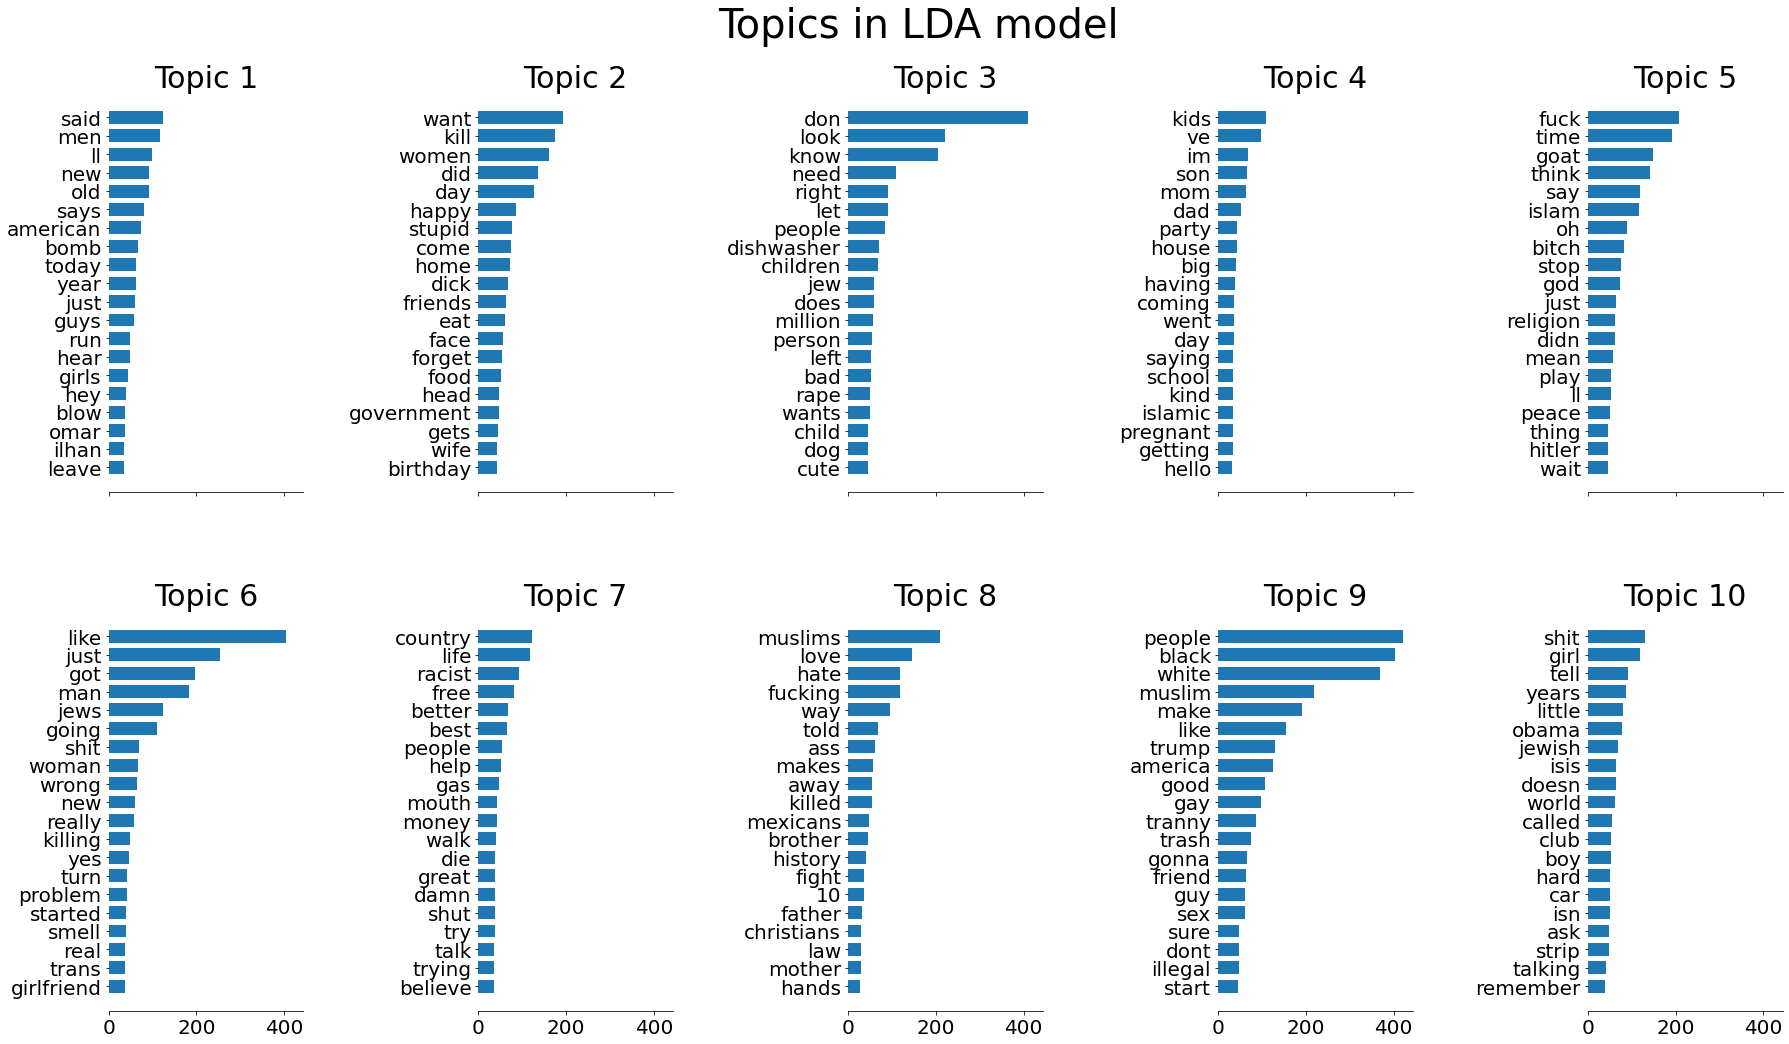

In [22]:
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

Maybe some interesting things with "black" and "white" being put together... there's also things like "muslims" and "kill" being associated with eachother.

In [23]:
from transformers import GPT2Model, GPT2Config, GPT2ForSequenceClassification, GPT2Tokenizer

In [24]:
# Get GPT2 Model
# gpt2_model = GPT2ForSequenceClassification.from_pretrained('gpt2')

In [25]:
### finetuning resnet
import torch.nn as nn
from torch.optim import Adam

In [26]:
# num_ftrs = gpt2_model.score.in_features
# gpt2_model.score = nn.Linear(num_ftrs, 2_000)

In [27]:
# gpt2_model = gpt2_model.cuda()

In [28]:
# GPT2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [29]:
dev_data_np = get_dev_images()

In [30]:
class concat_model(nn.Module):
    def __init__(self):
        super(concat_model, self).__init__()
        
        self.gpt2_model = GPT2ForSequenceClassification.from_pretrained('gpt2-large')
        num_ftrs = self.gpt2_model.score.in_features
        self.gpt2_model.score = nn.Linear(num_ftrs, 2_000)
        
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        
        self.vision_model = torchvision.models.resnet152(pretrained=True)
        num_ftrs = self.vision_model.fc.in_features
        self.vision_model.fc = nn.Linear(num_ftrs, 2000)
        input_size = 224
        self.vision_model = self.vision_model
        
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

        self.linear1 = nn.Linear(4000, 2000)
        self.linear2 = nn.Linear(2000, 2000)
        self.linear3 = nn.Linear(2000, 2000)
        self.linear4 = nn.Linear(2000, 2)
        
    def forward(self, data):
        images = data[0]
        gpt2_encoded = data[1]
            
        vision_out = self.vision_model(images)
        
        
        all_out = []
        for w in range(len(gpt2_encoded)):
            gpt2_out = self.gpt2_model(gpt2_encoded[w])[0]
            all_out.append(gpt2_out[0])
        gpt2_out = torch.stack(all_out)
        
        cat = torch.cat((vision_out,gpt2_out),dim=1)

        out1 = self.linear1(cat)
        out1 = self.relu(out1)
        out1 = self.linear2(out1)
        out1 = self.relu(out1)
        out1 = self.linear3(out1)
        out1 = self.relu(out1)
        out1 = self.linear4(out1)
        
        return out1

In [31]:
cc = concat_model()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
unfrozen = [
    "linear1.weight",
    "linear1.bias",
    "linear2.weight",
    "linear2.bias",
    "linear3.weight",
    "linear3.bias",
    "linear4.weight",
    "linear4.bias",
]

for name, param in cc.named_parameters():
    if name not in unfrozen:
        param.requires_grad = False 

In [33]:
cc = cc.cuda()

In [34]:
X_img_tr, y_tr, X_text_tr = training_data_np[0], training_data_np[1], training_data_np[2]
X_img_dev, y_dev, X_text_dev = dev_data_np[0], dev_data_np[1], dev_data_np[2]

In [35]:
X_text_tr = np.array(X_text_tr)
X_text_dev = np.array(X_text_dev)

In [36]:
optimizer = Adam(cc.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

In [37]:
len(X_text_tr)

8500

In [38]:
def get_enc_gpt(text):
    all_out = []
    for w in range(len(text)):
        inputs = torch.tensor([tokenizer.encode(text[w])])
        all_out.append(inputs.cuda())

    return all_out

In [39]:
softmax = torch.nn.Softmax(dim=1)

In [40]:
batch_size = 64

all_dev_accs = []

## Finetune vision model
for _ in tqdm_n(range(5)):
    perm = np.random.permutation(X_img_tr.shape[0])
    
    cc.train()

    for j in tqdm_n(range(0, X_img_tr.shape[0], batch_size)):
        cur_x_img = X_img_tr[perm[j:j+batch_size]].cuda()
        cur_x_text = X_text_tr[perm[j:j+batch_size]]
        cur_y = y_tr[perm[j:j+batch_size]].cuda()
        
        gpt_encoded = get_enc_gpt(cur_x_text)
        out = cc([cur_x_img, gpt_encoded])
        l_out = loss(out, cur_y)
         
        optimizer.zero_grad()
        l_out.backward()
        optimizer.step()
                                
    cc.eval()
                        
    # validation loss
    accs = []
    for q in tqdm_n(range(0, X_img_dev.shape[0], batch_size)):
        cur_x_img = X_img_dev[q:q+batch_size].cuda()
        cur_x_text = X_text_dev[q:q+batch_size]
        cur_y = y_dev[q:q+batch_size].cuda()
                
        gpt_encoded = get_enc_gpt(cur_x_text)
        predictions = softmax(cc([cur_x_img,gpt_encoded]))
        arg_preds = torch.argmax(predictions, dim=1)
        acc = torch.sum(cur_y == arg_preds).float() / cur_y.shape[0]
        accs.append(acc.detach().cpu().numpy())
        
    dev_acc = np.mean(accs)
    print("Dev Acc", dev_acc)
    
    all_dev_accs.append(dev_acc)
    


Dev Acc 0.5455228


Dev Acc 0.5670072


Dev Acc 0.57421875


Dev Acc 0.5518329


Dev Acc 0.5841346



In [44]:
torch.save(cc.state_dict(), "./gpt-resnet.torch")

In [54]:
tensor_img, labels, text = get_test_images()

In [58]:
preds = []
glabels = []
for q in tqdm_n(range(0, tensor_img.shape[0], batch_size)):
    cur_x_img = tensor_img[q:q+batch_size].cuda()
    cur_x_text = text[q:q+batch_size]
    cur_y = labels[q:q+batch_size].cuda()

    gpt_encoded = get_enc_gpt(cur_x_text)
    predictions = softmax(cc([cur_x_img,gpt_encoded]))
    arg_preds = torch.argmax(predictions, dim=1)
    
    preds.append(arg_preds.detach().cpu())
    glabels.append(cur_y.detach().cpu())
    
preds = np.concatenate(preds)
glabels = np.concatenate(glabels)
acc = np.sum(glabels == preds).astype(float) / glabels.shape[0]
print("Test Acc", acc)

Test Acc 0.582
